/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


<IPython.core.display.Javascript object>


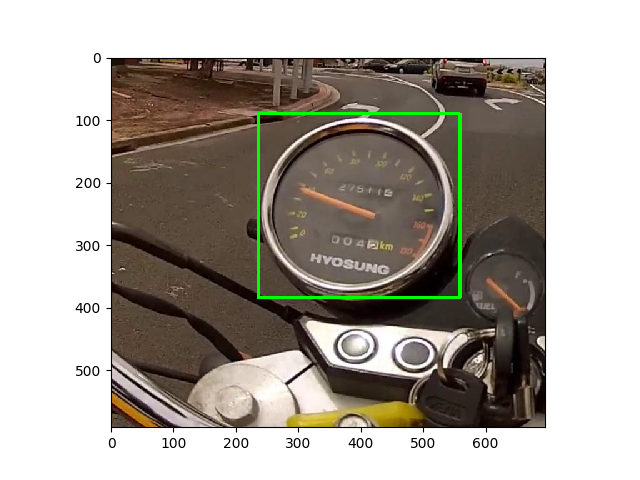

<IPython.core.display.Javascript object>


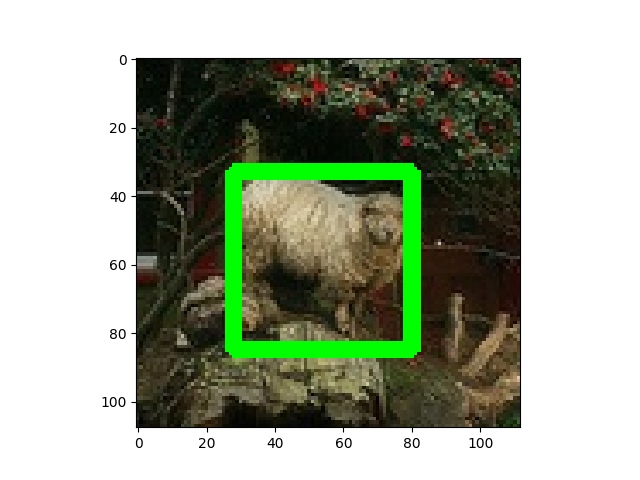

<IPython.core.display.Javascript object>


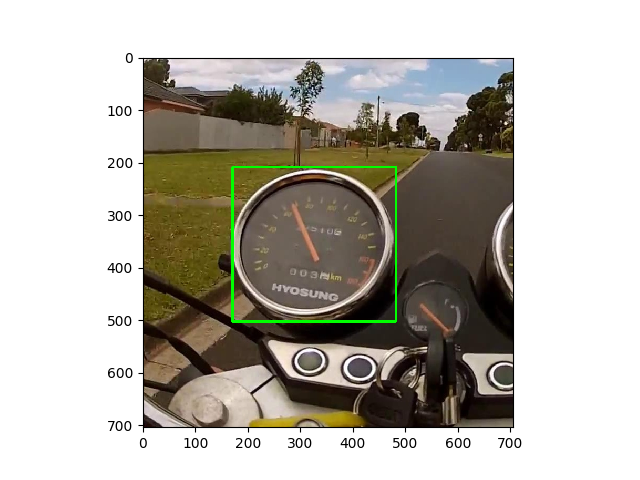

<IPython.core.display.Javascript object>


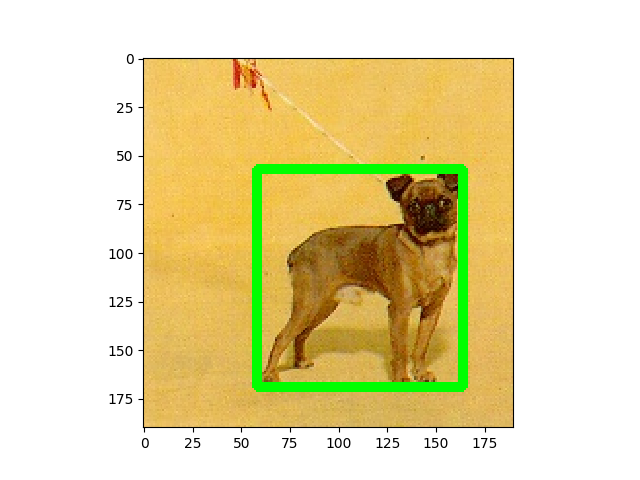

In [2]:
import cv2
import tensorflow as tf
import tensorboard
import numpy as np
from matplotlib import pyplot as plt
import glob
from random import shuffle
from IPython.display import Image
%matplotlib notebook

def viewer(img):
    fig = plt.figure()
    #plt.imshow(cv2.resize(img[:,:,::-1], (227,227)))
    plt.imshow(img[:,:,::-1])
    fig.show()

counter = 0
targetFileName = 'none'
alovTrainFileLines = [line.rstrip() for line in open("./trainSet.txt").readlines()]
for lineIdx in range(30000, len(alovTrainFileLines), 1):
    parseLine = alovTrainFileLines[lineIdx].split(',')
    target = cv2.imread(parseLine[0])
    search = cv2.imread(parseLine[1])
    [bbx1, bby1, bbx2, bby2] = [int(float(parseLine[2])*search.shape[1]), int(float(parseLine[3])*search.shape[0]), int(float(parseLine[4])*search.shape[1]), int(float(parseLine[5])*search.shape[0])]
    cv2.rectangle(search, (bbx1, bby1), (bbx2 ,bby2), (0,255,0), 3)
    if targetFileName != parseLine[0]:
        counter += 1
        if counter == 5:
            break
        #viewer(target)
    targetFileName = parseLine[0]
    viewer(search)

In [35]:
int(bbx1)

235

<IPython.core.display.Javascript object>


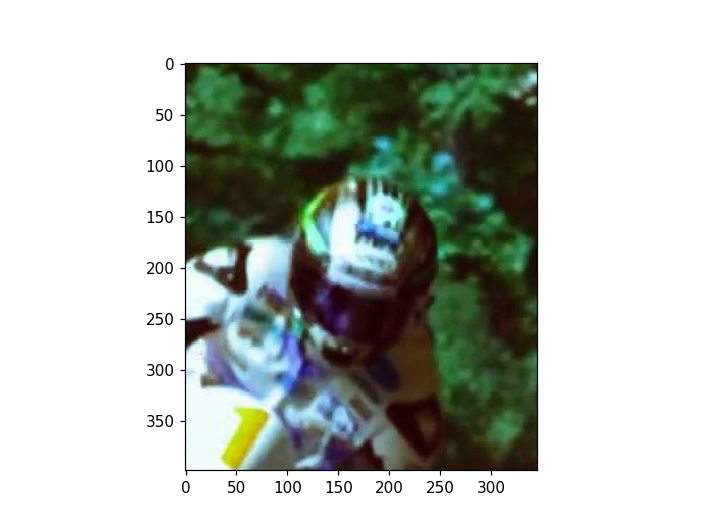

In [130]:
plt.imshow(im)
plt.show()

In [271]:
np.random.laplace(1, 1./5)

0.8910342090854066

In [433]:
import cv2
import tensorflow as tf
import tensorboard
import numpy as np
from matplotlib import pyplot as plt
import glob
import re
import os
import xml.etree.ElementTree as ET
from IPython.display import Image
%matplotlib notebook


# Augmentation params as in the paper
augShift = 1./5 
augScale = 1./15
minScale = 0.6
maxScale = 1.4
k1 = k2 = 2
k3 = 10

alovData = "./data/alovData"
alovDataGT = "./data/alovDataGT"
imageNetData = "./data/imageNetData"
imageNetDataGT = "./data/imageNetDataGT"
votData = "./data/votTestData"

alovExtdata = "./data/alovExtData"
if not os.path.exists(alovExtdata):
    os.mkdir(alovExtdata)

alovExtdataTarget = alovExtdata + "/target"
if not os.path.exists(alovExtdataTarget):
    os.mkdir(alovExtdataTarget)

alovExtdataSearching = alovExtdata + "/searching"
if not os.path.exists(alovExtdataSearching):
    os.mkdir(alovExtdataSearching)
    
imageNetExtdata = "./data/imageNetExtData"
if not os.path.exists(imageNetExtdata):
    os.mkdir(imageNetExtdata)

imageNetExtdataTarget = imageNetExtdata + "/target"
if not os.path.exists(imageNetExtdataTarget):
    os.mkdir(imageNetExtdataTarget)

imageNetExtdataSearching = imageNetExtdata + "/searching"
if not os.path.exists(imageNetExtdataSearching):
    os.mkdir(imageNetExtdataSearching)
    
votExtdata = "./data/votExtData"
if not os.path.exists(votExtdata):
    os.mkdir(votExtdata)
    
votExtdataTarget = votExtdata + "/target"
if not os.path.exists(votExtdataTarget):
    os.mkdir(votExtdataTarget)

votExtdataSearching = votExtdata + "/searching"
if not os.path.exists(votExtdataSearching):
    os.mkdir(votExtdataSearching)
    
    
def extBB(annParse):
    bbx1 = min(annParse[1],annParse[3],annParse[5],annParse[7])
    bby1 = min(annParse[2],annParse[4],annParse[6],annParse[8])
    bbx2 = max(annParse[1],annParse[3],annParse[5],annParse[7])
    bby2 = max(annParse[2],annParse[4],annParse[6],annParse[8])
    return [bbx1, bby1, bbx2, bby2]

def extBBvot(annParse):
    bbx1 = min(annParse[0],annParse[2],annParse[4],annParse[6])
    bby1 = min(annParse[1],annParse[3],annParse[5],annParse[7])
    bbx2 = max(annParse[0],annParse[2],annParse[4],annParse[6])
    bby2 = max(annParse[1],annParse[3],annParse[5],annParse[7])
    return [bbx1, bby1, bbx2, bby2]

def viewer(img):
    fig = plt.figure()
    #plt.imshow(cv2.resize(img[:,:,::-1], (227,227)))
    plt.imshow(img[:,:,::-1])
    fig.show()

def goturnAugmentation(augIdx, cxPrev, cyPrev, bbx1Prev, bby1Prev, bbx2Prev, bby2Prev, frameRes, bbx1Curr, bby1Curr, bbx2Curr, bby2Curr):
    width = bbx2Prev - bbx1Prev
    height = bby2Prev - bby1Prev 
    cxCurr = bbx1Prev + (width/2)
    cyCurr = bby1Prev + (height/2)
    newWidth = -1
    newHeight = -1
    newCx = -1
    newCy = -1
        
    if augIdx == 0:
        newHeight = frameCurr.shape[0]-1 if k2*height > frameCurr.shape[0]-1 else k2*height
        newWidth = frameCurr.shape[1]-1 if k2*width > frameCurr.shape[1]-1 else k2*width
        newCx = cxCurr
        newCy = cyCurr
        startCropCurrY = 0 if cyCurr-newHeight/2 < 0 else cyCurr-newHeight/2
        endCropCurrY = frameCurr.shape[0]-1 if cyCurr+newHeight/2 > frameCurr.shape[0]-1 else cyCurr+newHeight/2
        startCropCurrX = 0 if cxCurr-newWidth/2 < 0 else cxCurr-newWidth/2
        endCropCurrX = frameCurr.shape[1]-1 if cxCurr+newWidth/2 > frameCurr.shape[1]-1 else cxCurr+newWidth/2
        bbx1New = 0 if newCx-newWidth/2 < 0 else newCx-newWidth/2
        bby1New = 0 if newCy-newHeight/2 < 0 else newCy-newHeight/2
        
    else:    
        numOfTries = 10
        while (newWidth < 0 or newWidth > frameRes[1]-1) and numOfTries:
            scaleW = max(minScale, min(maxScale, np.random.laplace(1, augScale)))
            newWidth = int(k2*width*scaleW)
            numOfTries -= 1
            if numOfTries == 0:
                return [0, 0, 0, _, _, _, _, _, False]

        numOfTries = 10
        while (newHeight < 0 or newHeight > frameRes[0]-1) and numOfTries:
            scaleH = max(minScale, min(maxScale, np.random.laplace(1, augScale)))
            newHeight = int(k2*height*scaleH)
            numOfTries -= 1
            if numOfTries == 0:
                return [_, _, _, _, _, _, _, _, False]            
            
        numOfTries = 10
        firstIter = True
        while (firstIter or newCx < cxCurr-((width*k2)/2) or newCx > cxCurr+((width*k2)/2) or newCx-newWidth/2 < 0 or newCx+newWidth/2 > frameRes[1]-1) and numOfTries:
            newCx = cxCurr + width*np.random.laplace(0, augShift)
            newCx = int(min(frameRes[1]-newWidth/2, max(newWidth/2,newCx)))
            numOfTries -= 1
            firstIter = False
            if numOfTries == 0:
                return [_, _, _, _, _, _, _, _, False]

        numOfTries = 10
        firstIter = True
        while (firstIter or newCy < cyCurr-((height*k2)/2) or newCy > cyCurr+((height*k2)/2) or newCy-newHeight/2 < 0 or newCy+newHeight/2 > frameRes[0]-1) and numOfTries:
            newCy = cyCurr + height*np.random.laplace(0, augShift)
            newCy = int(min(frameRes[1]-newHeight/2, max(newHeight/2,newCy)))
            numOfTries -= 1
            firstIter = False
            if numOfTries == 0:
                return [_, _, _, _, _, _, _, _, False]
    
        bbx1New = newCx - newWidth/2
        bbx2New = newCx + newWidth/2
        bby1New = newCy - newHeight/2
        bby2New = newCy + newHeight/2

        startCropCurrY = bby1New
        endCropCurrY = bby2New
        startCropCurrX = bbx1New
        endCropCurrX = bbx2New

    
    bbx1CurrCrop = 0 if bbx1Curr-bbx1New < 0 else bbx1Curr-bbx1New
    bbx2CurrCrop = 0 if bbx2Curr-bbx1New < 0 else bbx2Curr-bbx1New
    bby1CurrCrop = 0 if bby1Curr-bby1New < 0 else bby1Curr-bby1New
    bby2CurrCrop = 0 if bby2Curr-bby1New < 0 else bby2Curr-bby1New
        
    return [bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop, startCropCurrY, endCropCurrY, startCropCurrX, endCropCurrX, True]
 
    
# Extract Alov data
print "Extracting Alov data..."

alovTrainSet = open("alovTrainSet.txt", "w")

categories = glob.glob(alovData + "/*")
for category in categories:
    if re.search("notToUseForTrain", category):
        print "skip ALOV duplication with VOT..."
        continue
    videos = glob.glob(category + "/*")
    for video in videos:
        videoAnn = re.sub("\/alovData\/", "/alovDataGT/", video)
        videoAnn = re.sub("$", ".ann", videoAnn)
        framesAnn = [line.rstrip() for line in open(videoAnn).readlines()]
        frames = glob.glob(video + "/*.jpg")
        frames.sort()
        if len(framesAnn) < 2:
            print "video {} have less then 2 annotated frames".format(video.split("/")[-1])
            continue
        for frameAnnIndx in xrange(1, len(framesAnn), 1):
            annParsePrev = [int(float(number)) for number in framesAnn[frameAnnIndx-1].split()]
            annParseCurr = [int(float(number)) for number in framesAnn[frameAnnIndx].split()]
            framePrev = cv2.imread(frames[annParsePrev[0]-1])
            frameCurr = cv2.imread(frames[annParseCurr[0]-1])
            [bbx1Prev, bby1Prev, bbx2Prev, bby2Prev] = extBB(annParsePrev) 
            [bbx1Curr, bby1Curr, bbx2Curr, bby2Curr] = extBB(annParseCurr)
            
            cxPrev = bbx1Prev + ((bbx2Prev - bbx1Prev)/2)
            cyPrev = bby1Prev + ((bby2Prev - bby1Prev)/2)
            bbPadsPrevH = k1*((bby2Prev - bby1Prev)/2)
            bbPadsPrevW = k1*((bbx2Prev - bbx1Prev)/2)
            
            startCropPrevY = 0 if cyPrev-bbPadsPrevH < 0 else cyPrev-bbPadsPrevH
            endCropPrevY = framePrev.shape[0]-1 if cyPrev+bbPadsPrevH > framePrev.shape[0]-1 else cyPrev+bbPadsPrevH
            startCropPrevX = 0 if cxPrev-bbPadsPrevW < 0 else cxPrev-bbPadsPrevW
            endCropPrevX = framePrev.shape[1]-1 if cxPrev+bbPadsPrevW > framePrev.shape[1]-1 else cxPrev+bbPadsPrevW
            
            framePrevCropPads = framePrev[startCropPrevY:endCropPrevY, startCropPrevX:endCropPrevX]
            fileNameTarget = "{}/{}_prev_{}".format(alovExtdataTarget, (frames[annParsePrev[0]-1].split("/"))[-2], annParsePrev[0])
            cv2.imwrite(fileNameTarget + ".jpg", framePrevCropPads)
            
            #viewer(framePrev)
            #cv2.rectangle(framePrev, (bbx1Prev,bby1Prev), (bbx2Prev,bby2Prev), (0,255,0), 3)
            #viewer(framePrevCropPads)
            for augIdx in range(k3):
                [bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop, startCropCurrY, endCropCurrY, startCropCurrX, endCropCurrX, valid] = goturnAugmentation(augIdx, cxPrev, cyPrev, bbx1Prev, bby1Prev, bbx2Prev, bby2Prev, frameCurr.shape[:2], bbx1Curr, bby1Curr, bbx2Curr, bby2Curr)
                if not valid:
                    continue
                frameCurrCropPads = frameCurr[startCropCurrY:endCropCurrY, startCropCurrX:endCropCurrX]
                fileNameSearch = "{}/{}_curr_{}_{}".format(alovExtdataSearching, (frames[annParseCurr[0]-1].split("/"))[-2], annParseCurr[0], augIdx)
                cv2.imwrite(fileNameSearch + ".jpg", frameCurrCropPads)
                annFile = open(fileNameSearch + ".ann", "w")
                annFile.write("{},{},{},{}".format(bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
                annFile.close()
                alovTrainSet.write("{}.jpg,{}.jpg,{},{},{},{}\n".format(fileNameTarget, fileNameSearch, bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
                #cv2.rectangle(frameCurrCropPads, (bbx1CurrCrop,bby1CurrCrop), (bbx2CurrCrop,bby2CurrCrop), (0,255,0), 3)
                #cv2.rectangle(frameCurr, (bbx1Curr,bby1Curr), (bbx2Curr,bby2Curr), (0,255,0), 3)  
                #viewer(frameCurrCropPads)
            

alovTrainSet.close()


# Extract ImageNet data
print "Extracting ImageNet data..."

imageNetTrainSet = open("imageNetTrainSet.txt", "w")

images = glob.glob(imageNetData + "/*/" + "/*")
imagesGT = glob.glob(imageNetDataGT + "/*/" + "/*")
images.sort()
imagesGT.sort()

for image in images:
    imageGT = re.sub("\/imageNetData\/", "/imageNetDataGT/", image)
    imageGT = re.sub("JPEG$", "xml", imageGT)
    
    xmlTree = ET.parse(imageGT)
    root = xmlTree.getroot()
    
    if len(root.findall('object')) != 1:
        print "{} has no object annotated".format(image)
        continue
        
    framePrev = cv2.imread(image)
    
    obj = root.find('object')
    bbElement = obj.find('bndbox')
    [bbx1Prev, bby1Prev, bbx2Prev, bby2Prev] = [int(bbElement.find('xmin').text), int(bbElement.find('ymin').text), int(bbElement.find('xmax').text), int(bbElement.find('ymax').text)]
        
    cxPrev = bbx1Prev + ((bbx2Prev - bbx1Prev)/2)
    cyPrev = bby1Prev + ((bby2Prev - bby1Prev)/2)
    bbPadsPrevH = k1*((bby2Prev - bby1Prev)/2)
    bbPadsPrevW = k1*((bbx2Prev - bbx1Prev)/2)

    startCropPrevY = 0 if cyPrev-bbPadsPrevH < 0 else cyPrev-bbPadsPrevH
    endCropPrevY = framePrev.shape[0]-1 if cyPrev+bbPadsPrevH > framePrev.shape[0]-1 else cyPrev+bbPadsPrevH
    startCropPrevX = 0 if cxPrev-bbPadsPrevW < 0 else cxPrev-bbPadsPrevW
    endCropPrevX = framePrev.shape[1]-1 if cxPrev+bbPadsPrevW > framePrev.shape[1]-1 else cxPrev+bbPadsPrevW

    framePrevCropPads = framePrev[startCropPrevY:endCropPrevY, startCropPrevX:endCropPrevX]
    fileNameTarget = "{}/{}_prev".format(imageNetExtdataTarget, image.split("/")[-1][:-5])
    cv2.imwrite(fileNameTarget + ".jpg", framePrevCropPads)

    #cv2.rectangle(framePrev, (bbx1Prev,bby1Prev), (bbx2Prev,bby2Prev), (0,255,0), 3)
    #viewer(framePrevCropPads)
    
    for augIdx in range(1,k3):
        [bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop, startCropCurrY, endCropCurrY, startCropCurrX, endCropCurrX, valid] = goturnAugmentation(augIdx, cxPrev, cyPrev, bbx1Prev, bby1Prev, bbx2Prev, bby2Prev, framePrev.shape[:2], bbx1Prev, bby1Prev, bbx2Prev, bby2Prev)
        if not valid:
            continue
        frameCurrCropPads = framePrev[startCropCurrY:endCropCurrY, startCropCurrX:endCropCurrX]
        fileNameSearch = "{}/{}_curr_{}".format(imageNetExtdataSearching, image.split("/")[-1][:-5], augIdx)
        cv2.imwrite(fileNameSearch + ".jpg", frameCurrCropPads)
        annFile = open(fileNameSearch + ".ann", "w")
        annFile.write("{},{},{},{}".format(bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
        annFile.close()
        imageNetTrainSet.write("{}.jpg,{}.jpg,{},{},{},{}\n".format(fileNameTarget, fileNameSearch, bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
        #cv2.rectangle(frameCurrCropPads, (bbx1CurrCrop,bby1CurrCrop), (bbx2CurrCrop,bby2CurrCrop), (0,255,0), 3) 
        #viewer(frameCurrCropPads)
        

imageNetTrainSet.close() 


# Extract vot data
print "Extracting VOT data..."

votTestSet = open("votTestSet.txt", "w")

videos = glob.glob(votData + "/*")
for video in videos:
    if re.search("list\.txt", video):
        print "skip category list file"
        continue
    videoAnn = video + "/groundtruth.txt"
    framesAnn = [line.rstrip() for line in open(videoAnn).readlines()]
    frames = glob.glob(video + "/*.jpg")
    frames.sort()
    if len(framesAnn) < 5:
        print "video {} is shorter then 5 frames".format(video.split("/")[-1])
        continue
    for frameAnnIndx in xrange(4, len(framesAnn), 1):
        annParsePrev = [int(float(number)) for number in framesAnn[frameAnnIndx-4].split(',')]
        annParseCurr = [int(float(number)) for number in framesAnn[frameAnnIndx].split(',')]
        framePrev = cv2.imread(frames[frameAnnIndx-4])
        frameCurr = cv2.imread(frames[frameAnnIndx])
        [bbx1Prev, bby1Prev, bbx2Prev, bby2Prev] = extBBvot(annParsePrev) 
        [bbx1Curr, bby1Curr, bbx2Curr, bby2Curr] = extBBvot(annParseCurr)

        cxPrev = bbx1Prev + ((bbx2Prev - bbx1Prev)/2)
        cyPrev = bby1Prev + ((bby2Prev - bby1Prev)/2)
        bbPadsPrevH = k1*((bby2Prev - bby1Prev)/2)
        bbPadsPrevW = k1*((bbx2Prev - bbx1Prev)/2)

        startCropPrevY = 0 if cyPrev-bbPadsPrevH < 0 else cyPrev-bbPadsPrevH
        endCropPrevY = framePrev.shape[0]-1 if cyPrev+bbPadsPrevH > framePrev.shape[0]-1 else cyPrev+bbPadsPrevH
        startCropPrevX = 0 if cxPrev-bbPadsPrevW < 0 else cxPrev-bbPadsPrevW
        endCropPrevX = framePrev.shape[1]-1 if cxPrev+bbPadsPrevW > framePrev.shape[1]-1 else cxPrev+bbPadsPrevW

        framePrevCropPads = framePrev[startCropPrevY:endCropPrevY, startCropPrevX:endCropPrevX]
        fileNameTarget = "{}/{}_prev_{}".format(votExtdataTarget, video.split("/")[-1], frames[frameAnnIndx-5].split("/")[-1][:-4])
        cv2.imwrite(fileNameTarget + ".jpg", framePrevCropPads)

        #viewer(framePrev)
        #cv2.rectangle(framePrev, (bbx1Prev,bby1Prev), (bbx2Prev,bby2Prev), (0,255,0), 3)
        #viewer(framePrevCropPads)
        for augIdx in range(k3):
            [bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop, startCropCurrY, endCropCurrY, startCropCurrX, endCropCurrX, valid] = goturnAugmentation(augIdx, cxPrev, cyPrev, bbx1Prev, bby1Prev, bbx2Prev, bby2Prev, frameCurr.shape[:2], bbx1Curr, bby1Curr, bbx2Curr, bby2Curr)
            if not valid:
                continue
            frameCurrCropPads = frameCurr[startCropCurrY:endCropCurrY, startCropCurrX:endCropCurrX]
            fileNameSearch = "{}/{}_curr_{}_{}".format(votExtdataSearching, video.split("/")[-1], frames[frameAnnIndx].split("/")[-1][:-4], augIdx)
            cv2.imwrite(fileNameSearch + ".jpg", frameCurrCropPads)
            annFile = open(fileNameSearch + ".ann", "w")
            annFile.write("{},{},{},{}".format(bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
            annFile.close()
            votTestSet.write("{}.jpg,{}.jpg,{},{},{},{}\n".format(fileNameTarget, fileNameSearch, bbx1CurrCrop, bby1CurrCrop, bbx2CurrCrop, bby2CurrCrop))
            cv2.rectangle(frameCurrCropPads, (bbx1CurrCrop,bby1CurrCrop), (bbx2CurrCrop,bby2CurrCrop), (0,255,0), 3)
            #cv2.rectangle(frameCurr, (bbx1Curr,bby1Curr), (bbx2Curr,bby2Curr), (0,255,0), 3)  
            #viewer(frameCurrCropPads)


votTestSet.close()

Extracting Alov data...


KeyboardInterrupt: 

> <ipython-input-433-4f4c49df8873>(186)<module>()
    184             annParsePrev = [int(float(number)) for number in framesAnn[frameAnnIndx-1].split()]
    185             annParseCurr = [int(float(number)) for number in framesAnn[frameAnnIndx].split()]
--> 186             framePrev = cv2.imread(frames[annParsePrev[0]-1])
    187             frameCurr = cv2.imread(frames[annParseCurr[0]-1])
    188             [bbx1Prev, bby1Prev, bbx2Prev, bby2Prev] = extBB(annParsePrev)


KeyboardInterrupt


In [306]:
#import pickle
#fileName = "{}/{}_curr_{}_{}.pkl".format(alovExtdata, (frames[annParseCurr[0]].split("/"))[-2], annParseCurr[0], augIdx)
#pickle.dump([bbx1Curr,bby1Curr, bbx2Curr, bby2Curr], open(fileName, "wb" ) )
#ann = pickle.load( open("{}/{}_curr_{}_{}.pkl".format(alovExtdata, (frames[annParseCurr[0]].split("/"))[-2], annParseCurr[0], augIdx), "rb" ) )


In [30]:
from random import shuffle

alovTrainFileLines = [line.rstrip() for line in open("./alovTrainSet.txt").readlines()]
imageNetTrainFileLines = [line.rstrip() for line in open("./imageNetTrainSet.txt").readlines()]
shuffle(alovTrainFileLines)
shuffle(imageNetTrainFileLines)
trainSet = open("trainSet.txt", "w")
trainSetLenght = max(len(imageNetTrainFileLines), len(alovTrainFileLines))
for i in range(trainSetLenght):
    idxForShortList = i % min(len(imageNetTrainFileLines), len(alovTrainFileLines))
    parseLineAlov = alovTrainFileLines[idxForShortList].split(',')
    parseLineImageNet = imageNetTrainFileLines[i].split(',')
    searchAlov = cv2.imread(parseLineAlov[1])
    searchImageNet = cv2.imread(parseLineImageNet[1])
    heightAlov = searchAlov.shape[0]
    widhtAlov = searchAlov.shape[1]
    heightImageNet = searchImageNet.shape[0]
    widhtImageNet = searchImageNet.shape[1]
    # Write Alov
    [bbx1, bby1, bbx2, bby2] = [float(parseLineAlov[2])/widhtAlov, float(parseLineAlov[3])/heightAlov, float(parseLineAlov[4])/widhtAlov, float(parseLineAlov[5])/heightAlov]
    trainSet.write("{},{},{},{},{},{}\n".format(parseLineAlov[0], parseLineAlov[1], bbx1, bby1, bbx2, bby2))
    # Write Alov
    [bbx1, bby1, bbx2, bby2] = [float(parseLineImageNet[2])/widhtImageNet, float(parseLineImageNet[3])/heightImageNet, float(parseLineImageNet[4])/widhtImageNet, float(parseLineImageNet[5])/heightImageNet]
    trainSet.write("{},{},{},{},{},{}\n".format(parseLineImageNet[0], parseLineImageNet[1], bbx1, bby1, bbx2, bby2))
    
trainSet.close()

<IPython.core.display.Javascript object>


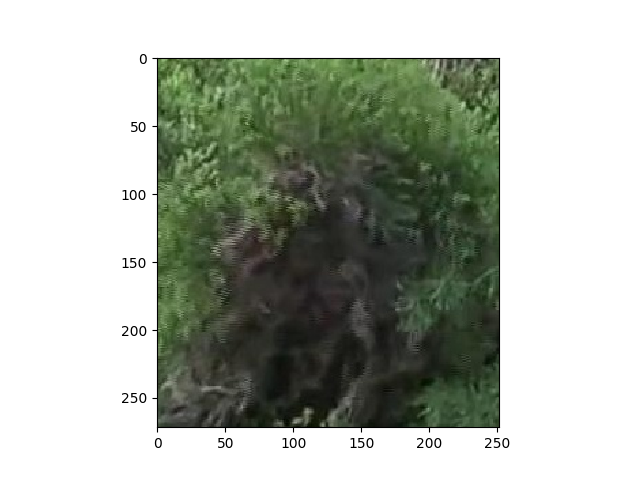

<IPython.core.display.Javascript object>


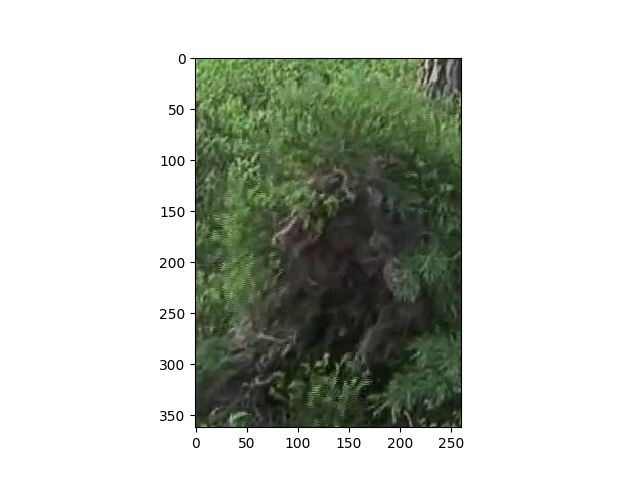

In [7]:
idx = 2000
alovTrainFileLines = [line.rstrip() for line in open("./alovTrainSet.txt").readlines()]
parseLineAlov = alovTrainFileLines[idx].split(',')
targetAlov = cv2.imread(parseLineAlov[0])
searchAlov = cv2.imread(parseLineAlov[1])
viewer(targetAlov)
viewer(searchAlov)

In [266]:
import os
%pdb
for root, dirs, files in os.walk(alovData):
    print root, dirs, files

Automatic pdb calling has been turned ON
./data/alovData ['10-LowContrast', '12-MovingCamera', '06-MotionSmoothness', '04-Transparency', '13-ZoomingCamera', 'notToUseForTrain', '01-Light', '08-Clutter', '05-Shape', '03-Specularity', '14-LongDuration', '02-SurfaceCover', '09-Confusion', '11-Occlusion', '07-MotionCoherence'] []
./data/alovData/10-LowContrast ['10-LowContrast_video00011', '10-LowContrast_video00002', '10-LowContrast_video00018', '10-LowContrast_video00010', '10-LowContrast_video00012', '10-LowContrast_video00017', '10-LowContrast_video00007', '10-LowContrast_video00022', '10-LowContrast_video00003', '10-LowContrast_video00014', '10-LowContrast_video00006', '10-LowContrast_video00001', '10-LowContrast_video00021', '10-LowContrast_video00020', '10-LowContrast_video00005', '10-LowContrast_video00004', '10-LowContrast_video00019', '10-LowContrast_video00023', '10-LowContrast_video00015', '10-LowContrast_video00016', '10-LowContrast_video00008', '10-LowContrast_video00009'] []

./data/alovData/06-MotionSmoothness/06-MotionSmoothness_video00007 [] ['00000494.jpg', '00000437.jpg', '00000011.jpg', '00000036.jpg', '00000601.jpg', '00000713.jpg', '00000413.jpg', '00000592.jpg', '00000284.jpg', '00000397.jpg', '00000598.jpg', '00000362.jpg', '00000033.jpg', '00000164.jpg', '00000432.jpg', '00000752.jpg', '00000214.jpg', '00000396.jpg', '00000573.jpg', '00000014.jpg', '00000575.jpg', '00000744.jpg', '00000151.jpg', '00000490.jpg', '00000198.jpg', '00000091.jpg', '00000495.jpg', '00000107.jpg', '00000046.jpg', '00000285.jpg', '00000314.jpg', '00000256.jpg', '00000478.jpg', '00000403.jpg', '00000086.jpg', '00000690.jpg', '00000243.jpg', '00000774.jpg', '00000081.jpg', '00000083.jpg', '00000783.jpg', '00000039.jpg', '00000504.jpg', '00000696.jpg', '00000764.jpg', '00000170.jpg', '00000399.jpg', '00000110.jpg', '00000512.jpg', '00000143.jpg', '00000040.jpg', '00000182.jpg', '00000614.jpg', '00000017.jpg', '00000554.jpg', '00000105.jpg', '00000320.jpg', '00000421.jpg', '

./data/alovData/01-Light/01-Light_video00017 [] ['00000437.jpg', '00000011.jpg', '00000036.jpg', '00000413.jpg', '00000284.jpg', '00000397.jpg', '00000362.jpg', '00000033.jpg', '00000164.jpg', '00000432.jpg', '00000214.jpg', '00000396.jpg', '00000014.jpg', '00000151.jpg', '00000198.jpg', '00000091.jpg', '00000107.jpg', '00000046.jpg', '00000285.jpg', '00000314.jpg', '00000256.jpg', '00000403.jpg', '00000086.jpg', '00000243.jpg', '00000081.jpg', '00000083.jpg', '00000039.jpg', '00000170.jpg', '00000399.jpg', '00000110.jpg', '00000143.jpg', '00000040.jpg', '00000182.jpg', '00000017.jpg', '00000105.jpg', '00000320.jpg', '00000421.jpg', '00000150.jpg', '00000426.jpg', '00000092.jpg', '00000359.jpg', '00000393.jpg', '00000274.jpg', '00000158.jpg', '00000420.jpg', '00000032.jpg', '00000113.jpg', '00000450.jpg', '00000119.jpg', '00000248.jpg', '00000369.jpg', '00000118.jpg', '00000068.jpg', '00000197.jpg', '00000443.jpg', '00000200.jpg', '00000291.jpg', '00000364.jpg', '00000108.jpg', '000002

./data/alovData/05-Shape/05-Shape_video00023 [] ['00001714.jpg', '00002396.jpg', '00002341.jpg', '00002986.jpg', '00003173.jpg', '00001153.jpg', '00002574.jpg', '00001490.jpg', '00001058.jpg', '00002636.jpg', '00000494.jpg', '00000808.jpg', '00002573.jpg', '00001687.jpg', '00002130.jpg', '00003315.jpg', '00000437.jpg', '00000011.jpg', '00002339.jpg', '00000036.jpg', '00003152.jpg', '00001642.jpg', '00002914.jpg', '00001163.jpg', '00002116.jpg', '00000601.jpg', '00002674.jpg', '00000713.jpg', '00001516.jpg', '00001407.jpg', '00001365.jpg', '00001306.jpg', '00000826.jpg', '00001554.jpg', '00002997.jpg', '00002239.jpg', '00001162.jpg', '00001667.jpg', '00001761.jpg', '00000413.jpg', '00000592.jpg', '00000993.jpg', '00001859.jpg', '00003095.jpg', '00001092.jpg', '00000284.jpg', '00003091.jpg', '00002353.jpg', '00003058.jpg', '00002908.jpg', '00003138.jpg', '00003093.jpg', '00001266.jpg', '00001688.jpg', '00002066.jpg', '00000397.jpg', '00001051.jpg', '00003283.jpg', '00003331.jpg', '000026

./data/alovData/14-LongDuration/14-LongDuration_video00004 [] ['00001714.jpg', '00002396.jpg', '00002341.jpg', '00002986.jpg', '00003173.jpg', '00001153.jpg', '00002574.jpg', '00001490.jpg', '00001058.jpg', '00002636.jpg', '00000494.jpg', '00000808.jpg', '00003466.jpg', '00002573.jpg', '00001687.jpg', '00002130.jpg', '00003315.jpg', '00000437.jpg', '00000011.jpg', '00002339.jpg', '00000036.jpg', '00003618.jpg', '00003152.jpg', '00001642.jpg', '00003833.jpg', '00002914.jpg', '00001163.jpg', '00002116.jpg', '00000601.jpg', '00002674.jpg', '00000713.jpg', '00001516.jpg', '00001407.jpg', '00003820.jpg', '00001365.jpg', '00001306.jpg', '00000826.jpg', '00001554.jpg', '00002997.jpg', '00002239.jpg', '00001162.jpg', '00001667.jpg', '00001761.jpg', '00000413.jpg', '00000592.jpg', '00000993.jpg', '00001859.jpg', '00003095.jpg', '00003519.jpg', '00001092.jpg', '00000284.jpg', '00003719.jpg', '00003091.jpg', '00002353.jpg', '00003710.jpg', '00003058.jpg', '00003917.jpg', '00003503.jpg', '00002908

./data/alovData/11-Occlusion/11-Occlusion_video00033 [] ['00000011.jpg', '00000036.jpg', '00000284.jpg', '00000033.jpg', '00000164.jpg', '00000214.jpg', '00000014.jpg', '00000151.jpg', '00000198.jpg', '00000091.jpg', '00000107.jpg', '00000046.jpg', '00000285.jpg', '00000256.jpg', '00000086.jpg', '00000243.jpg', '00000081.jpg', '00000083.jpg', '00000039.jpg', '00000170.jpg', '00000110.jpg', '00000143.jpg', '00000040.jpg', '00000182.jpg', '00000017.jpg', '00000105.jpg', '00000150.jpg', '00000092.jpg', '00000274.jpg', '00000158.jpg', '00000032.jpg', '00000113.jpg', '00000119.jpg', '00000248.jpg', '00000118.jpg', '00000068.jpg', '00000197.jpg', '00000200.jpg', '00000291.jpg', '00000108.jpg', '00000225.jpg', '00000026.jpg', '00000020.jpg', '00000194.jpg', '00000030.jpg', '00000295.jpg', '00000131.jpg', '00000192.jpg', '00000121.jpg', '00000132.jpg', '00000136.jpg', '00000287.jpg', '00000267.jpg', '00000096.jpg', '00000183.jpg', '00000196.jpg', '00000241.jpg', '00000171.jpg', '00000165.jpg',